In [1]:
import os
import re
import collections

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer

import chardet

DATA_PATH = 'data'
%matplotlib inline

In [2]:
data_list = os.listdir(DATA_PATH)
data_list

['glove.twitter.27B.100d.txt',
 'keywords.csv',
 'links.csv',
 'glove.6B.50d.txt',
 'clean.csv',
 'ratings.csv',
 'glove.twitter.27B.50d.txt',
 'glove.twitter.27B.25d.txt',
 'glove.twitter.27B.200d.txt',
 'crawl-300d-2M.vec',
 'credits.csv',
 'ratings_small.csv',
 'links_small.csv',
 'movies_metadata.csv']

In [3]:
for file in data_list:
    if file.endswith('csv'):
        path = os.path.join(DATA_PATH, file)
        with open(path, 'rb') as rawdata:
            result = chardet.detect(rawdata.read(10000))
            print(file, result)

keywords.csv {'confidence': 1.0, 'encoding': 'ascii', 'language': ''}
links.csv {'confidence': 1.0, 'encoding': 'ascii', 'language': ''}
clean.csv {'confidence': 0.7525, 'encoding': 'utf-8', 'language': ''}
ratings.csv {'confidence': 1.0, 'encoding': 'ascii', 'language': ''}
credits.csv {'confidence': 1.0, 'encoding': 'ascii', 'language': ''}
ratings_small.csv {'confidence': 1.0, 'encoding': 'ascii', 'language': ''}
links_small.csv {'confidence': 1.0, 'encoding': 'ascii', 'language': ''}
movies_metadata.csv {'confidence': 0.99, 'encoding': 'utf-8', 'language': ''}


In [4]:
df1 = pd.read_csv(os.path.join(DATA_PATH, 'credits.csv'))
df2 = pd.read_csv(os.path.join(DATA_PATH, 'movies_metadata.csv'))

/usr/local/lib/python3.4/dist-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
df1.columns

Index(['cast', 'crew', 'id'], dtype='object')

In [6]:
df2.columns

Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count'],
      dtype='object')

In [7]:
df2['id'] = pd.to_numeric(df2['id'], errors='coerce', downcast='integer')

In [8]:
df = pd.merge(left=df1, right=df2, on='id', how='inner')
del df1, df2
df = df.drop_duplicates()
# drop not very informative features
df = df.drop(labels=['imdb_id', 'poster_path', 'homepage', 'video', 'spoken_languages'], axis=1)
df.shape

(45462, 21)

In [9]:
# Extract year, month and day of week of movie release
df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')
df['year'] = df['release_date'].dt.year 
df['month'] = df['release_date'].dt.month 
df['day_of_week'] = df['release_date'].dt.weekday_name 

In [10]:
df[df['original_title'] != df['title']][['title', 'original_title']].head()

,title,original_title
28,The City of Lost Children,La Cité des Enfants Perdus
29,Shanghai Triad,摇啊摇，摇到外婆桥
32,Wings of Courage,"Guillaumet, les ailes du courage"
57,The Postman,Il postino
58,The Confessional,Le confessionnal


In [11]:
# original_title refers to the title of the movie in the native language
df = df.drop(labels=['original_title'], axis=1)

In [12]:
df['adult'].value_counts()

False    45453
True         9
Name: adult, dtype: int64

In [13]:
# there are only 9 films with adult rating
df = df.drop(labels=['adult'], axis=1)

In [14]:
# try to cast revenue and budget to numeric values
df['budget'] = pd.to_numeric(df['budget'], errors='coerce')

In [15]:
# a lot of zero values in revenue and budget columns
df[df['revenue'] == 0].shape, df[df['budget'] == 0].shape

((38049, 22), (36566, 22))

In [16]:
# convert zero values to NaN
df['revenue'] = df['revenue'].replace(0, np.nan)
df['budget'] = df['budget'].replace(0, np.nan)
df['runtime'] = df['runtime'].replace(0, np.nan)

In [17]:
# there are some unrealistic movies with budget and revenue equal 1$ and with length 1 minute
df[['revenue', 'budget', 'runtime']].describe()

,revenue,budget,runtime
count,7.410000e+03,8.896000e+03,43645.000000
mean,6.877770e+07,2.159949e+07,97.486562
std,1.464017e+08,3.430080e+07,34.648317
min,1.000000e+00,1.000000e+00,1.000000
25%,2.400000e+06,2.000000e+06,86.000000
50%,1.683423e+07,8.000000e+06,95.000000
75%,6.719821e+07,2.500000e+07,107.000000
max,2.787965e+09,3.800000e+08,1256.000000


In [18]:
# put NaN on movie with budget or revenue less 5000 and shorter than 5 minutes
df.loc[df['budget'] < 10000, 'budget'] = np.nan
df.loc[df['revenue'] < 10000, 'revenue'] = np.nan
df.loc[df['runtime'] < 5, 'runtime'] = np.nan

In [19]:
# create new feature revenue divided by budget showing if film make more money than was spent on its creation
df['success'] = df['revenue'] / df['budget'] 

In [20]:
# huge values of success feature are not outliers
df.loc[df['success'] > 100, ['title', 'budget', 'revenue', 'success']]\
.sort_values(by='success', ascending=False).head(10)

,title,budget,revenue,success
14258,Paranormal Activity,15000.0,193355800.0,12890.386667
2606,The Blair Witch Project,60000.0,248000000.0,4133.333333
3565,Eraserhead,10000.0,7000000.0,700.000000
4330,The Way of the Dragon,130000.0,85000000.0,653.846154
2256,Pink Flamingos,12000.0,6000000.0,500.000000
7820,Super Size Me,65000.0,28575078.0,439.616585
31708,The Gallows,100000.0,42664410.0,426.644100
9494,Open Water,130000.0,54667954.0,420.522723
2354,The Texas Chain Saw Massacre,85000.0,30859000.0,363.047059
1917,Bambi,858000.0,267447150.0,311.709965


In [21]:
df['status'].value_counts()

Released           45014
Rumored              229
Post Production       98
In Production         20
Planned               15
Canceled               2
Name: status, dtype: int64

In [22]:
# take in account only released movies
df = df.loc[df['status'] == 'Released']
df = df.drop(labels=['status'], axis=1)

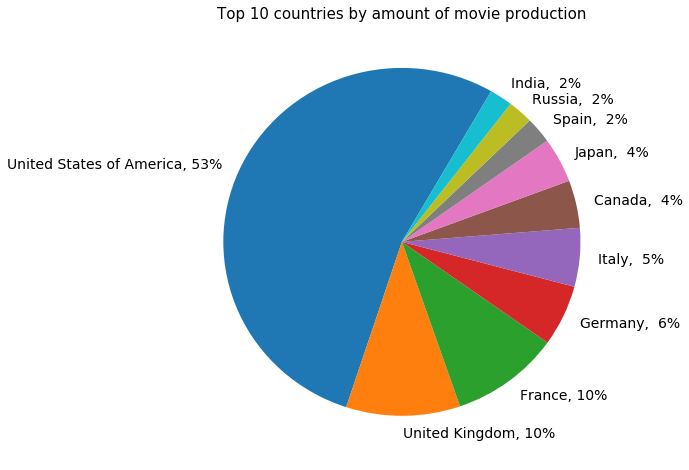

In [23]:
temp = df['production_countries'].str.extractall(r'\'name\': \'(?P<country>[\w\d\s]*)\'')\
.country.reset_index()['country']

temp = temp.value_counts().reset_index().head(10)
temp['percent'] = 100 * (temp['country'] / temp['country'].sum())

plt.figure(figsize=(8, 8))
plt.title('Top 10 countries by amount of movie production', size=15)
patches, texts = plt.pie(x=temp['country'], labels=temp['index'] + temp['percent'].apply(", {:2.0f}%".format), 
                         startangle=60)
[text.set_fontsize(14) for text in texts];

In [24]:
# create new feature that is first country from production countries
df['country_name'] = df['production_countries'].str.extract(r'\'name\': \'(?P<country>[\w\d\s]*)\'', expand=False)

In [25]:
# create new feature that is name of franchise if it exist
df['franchise_name'] = df['belongs_to_collection'].str.extract(r'\'name\': \'(?P<franchise>[\w\d\s]*)\'', 
                                                               expand=False)
# table with statistic (mean, sum of revenue and count of movies in franchise)
fran_pivot = df.pivot_table(index='franchise_name', values='revenue', 
                            aggfunc={'revenue': ['mean', 'sum', 'count']}).reset_index()

In [26]:
# most successful franchises (by total gross)
fran_pivot.sort_values('sum', ascending=False).head(5)

,franchise_name,count,mean,sum
452,Harry Potter Collection,8,9.634209e+08,7.707367e+09
926,Star Wars Collection,8,9.293118e+08,7.434495e+09
529,James Bond Collection,26,2.733450e+08,7.106970e+09
1059,The Fast and the Furious Collection,8,6.406373e+08,5.125099e+09
771,Pirates of the Caribbean Collection,5,9.043154e+08,4.521577e+09


In [27]:
# longest running franchises
fran_pivot.sort_values('count', ascending=False).head(5)

,franchise_name,count,mean,sum
529,James Bond Collection,26,2.733450e+08,7.106970e+09
389,Friday the 13th Collection,12,3.874155e+07,4.648985e+08
777,Pokémon Collection,11,6.348189e+07,6.983008e+08
926,Star Wars Collection,8,9.293118e+08,7.434495e+09
1059,The Fast and the Furious Collection,8,6.406373e+08,5.125099e+09


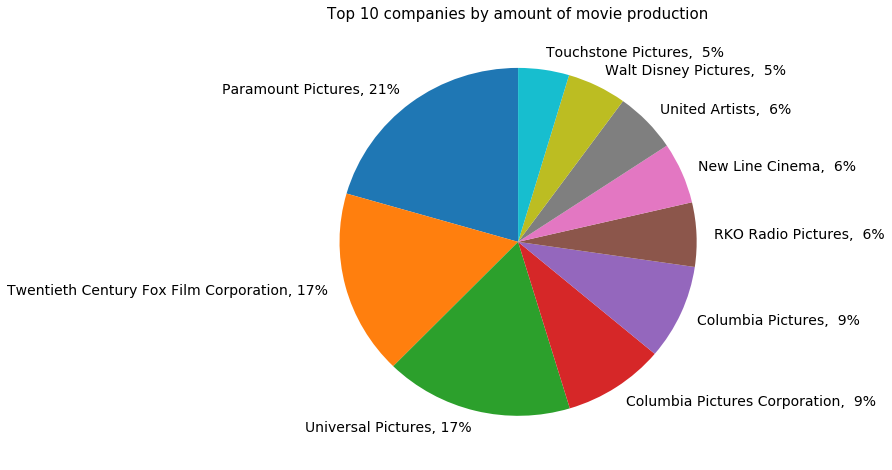

In [28]:
temp = df['production_companies'].str.extractall(r'\'name\': \'(?P<companie>[\w\d\s]*)\'')\
.reset_index()['companie']

temp = temp.value_counts().reset_index().head(10)
temp['percent'] = 100 * (temp['companie'] / temp['companie'].sum())

plt.figure(figsize=(8, 8))
plt.title('Top 10 companies by amount of movie production', size=15)
patches, texts = plt.pie(x=temp['companie'], labels=temp['index'] + temp['percent'].apply(", {:2.0f}%".format), 
                         startangle=90)
[text.set_fontsize(14) for text in texts];

In [29]:
# create new feature that is first company from production companies
df['companie_name'] = df['production_companies'].str.extract(r'\'name\': \'(?P<companie>[\w\d\s]*)\'', 
                                                               expand=True)

comp_pivot = df.pivot_table(index='companie_name', values='revenue', 
                            aggfunc={'revenue': ['mean', 'sum', 'count']}).reset_index()

In [30]:
# First and second place is Paramount Pictures and Universal Pictures both of them have 46 billion dollars in 
# revenue, third place is Walt Disney
comp_pivot.sort_values('sum', ascending=False).head(5)

,companie_name,count,mean,sum
6556,Paramount Pictures,385,1.216220e+08,4.682446e+10
9064,Universal Pictures,400,1.153156e+08,4.612623e+10
9314,Walt Disney Pictures,146,2.724741e+08,3.978121e+10
1983,Columbia Pictures,234,1.363581e+08,3.190780e+10
8947,Twentieth Century Fox Film Corporation,290,1.075268e+08,3.118277e+10


In [31]:
# In recent years Walt Disney takes leading position
comp_pivot = df.loc[df['year'] >= 2000].pivot_table(index='companie_name', values='revenue', 
                                                    aggfunc={'revenue': ['mean', 'sum', 'count']}).reset_index()
comp_pivot.sort_values('sum', ascending=False).head(5)

,companie_name,count,mean,sum
6081,Walt Disney Pictures,106,3.228229e+08,3.421923e+10
5902,Universal Pictures,188,1.667682e+08,3.135243e+10
4256,Paramount Pictures,163,1.821819e+08,2.969565e+10
1289,Columbia Pictures,145,1.943756e+08,2.818446e+10
5822,Twentieth Century Fox Film Corporation,112,1.726792e+08,1.934007e+10


In [32]:
# fill NA values
df['country_name'] = df['country_name'].fillna('unknown')
df['franchise_name'] = df['franchise_name'].fillna('unknown')
df['companie_name'] = df['companie_name'].fillna('unknown')

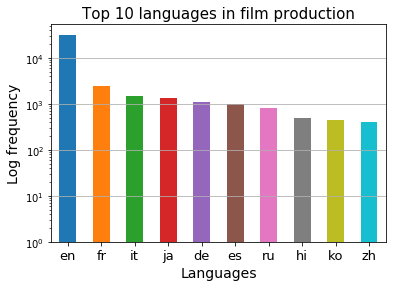

In [33]:
# There are about 10 times more movies in english than in any other language
df['original_language'].value_counts().head(10).plot(kind='bar', log=True)

plt.title('Top 10 languages in film production', size=15)
plt.grid(True, axis='y')
plt.ylabel('Log frequency', size=14)
plt.xlabel('Languages', size=14)
plt.xticks(size=13, rotation=0);

In [34]:
df['popularity'] = pd.to_numeric(df['popularity'], errors='coerce')
df['popularity'].describe()

count    45014.000000
mean         2.938845
std          6.023508
min          0.000000
25%          0.390898
50%          1.135355
75%          3.729833
max        547.488298
Name: popularity, dtype: float64

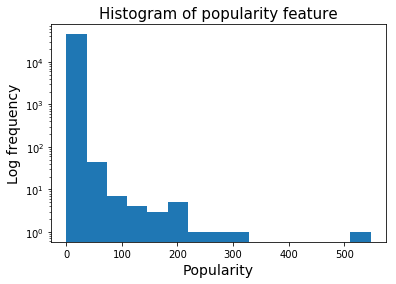

In [35]:
# Extremely skewed distribution
df['popularity'].plot(kind='hist', log=True, bins=15)

plt.title('Histogram of popularity feature', size=15)
plt.ylabel('Log frequency', size=14)
plt.xlabel('Popularity', size=14);

In [36]:
# Strange feature most "popular" films are quit new and there are very few of them
# It seems that these high values are outliers and should be scaled or dropped if sensitive model will be used
df.loc[df['popularity'] > 50, 'year'].describe()

count      36.000000
mean     2012.805556
std         7.970730
min      1982.000000
25%      2014.000000
50%      2016.000000
75%      2017.000000
max      2017.000000
Name: year, dtype: float64

In [37]:
# about 10% of movies has lowest or highest score
# most likely this is films with small amount of votes or they were artificially up voted to have highest score
df.loc[(df['vote_average'] == 0) | (df['vote_average'] == 10)].shape

(3118, 25)

In [38]:
# there are lots of movies with small amount votes, they can be influenced by outliers
# there is need in some transformation to show that this scores are not reliable
df.loc[df['vote_count'] <= 10].shape

(23343, 25)

In [39]:
# Names of directors, producers and other production positions
jobs = ['Director', 'Screenplay', 'Producer', 'Executive Producer', 'Music', 'Director of Photography']
paterns = [re.compile('\'job\': \'{}\', \'name\': \'([\w\s\d\.,-]*)\''.format(job)) for job in jobs]
for i, job in enumerate(jobs):
    df['crew_{}'.format(job)] = df['crew'].str.extract(paterns[i], expand=False)

# First five actors & actresses names
for act_number in range(3): 
    df['cast_{}'.format(act_number+1)] = df['cast'].str.split('\}, \{').str.get(act_number)\
    .str.extract('\'name\': \'([\w\s\d\.,-]*)\'', expand=False)
    df['cast_gender_{}'.format(act_number+1)] = df['cast'].str.split('\}, \{').str.get(act_number)\
    .str.extract('\'gender\': ([\d]*)', expand=False)

# First three genres from description
for genre_number in range(3):
    df['genres_{}'.format(genre_number+1)] = df['genres'].str.split('\}, \{').str.get(genre_number)\
    .str.extract('\'name\': \'([\w\s\d\.,-]*)\'', expand=False)    

In [40]:
df['cast_count'] = df['cast'].str.count('character')
df['crew_count'] = df['crew'].str.count('name')
df['country_count'] = df['production_countries'].str.count('name')
df['company_count'] = df['production_companies'].str.count('name')

In [41]:
# Table with 10 most productive directors and other roles in movie creators
temp = pd.DataFrame()

for job in jobs:
    p = re.compile('\'job\': \'{}\', \'name\': \'(?P<name>[\w\s\d\.,-]*)\''.format(job))
    temp = pd.concat([temp, 
                      df['crew'].str.extractall(p).reset_index()['name'].value_counts()\
                      .reset_index().head(5).rename(columns={'index': job, 'name': 'count_' + job[:3]})
                     ], axis=1)
temp

,Director,count_Dir,Screenplay,count_Scr,Producer,count_Pro,Executive Producer,count_Exe,Music,count_Mus,Director of Photography,count_Dir
0,John Ford,68,Ben Hecht,35,Darryl F. Zanuck,75,Bob Weinstein,101,Ennio Morricone,31,Charles Lang,78
1,Michael Curtiz,65,Woody Allen,33,Walt Disney,73,Harvey Weinstein,99,Mark Isham,28,Harry Stradling Sr.,66
2,Werner Herzog,55,Ernesto Gastaldi,30,Hal B. Wallis,69,Hal B. Wallis,60,John Debney,27,William H. Daniels,65
3,Alfred Hitchcock,53,Nunnally Johnson,29,Brian Grazer,67,Roger Corman,58,Theodore Shapiro,22,James Wong Howe,58
4,Georges Méliès,49,Dudley Nichols,29,Scott Rudin,62,Bruce Berman,57,Alan Silvestri,20,Joseph F. Biroc,54


In [42]:
# 2 male, 1, female, 0 unknown
(df['cast_gender_1'].value_counts() + df['cast_gender_2'].value_counts() + df['cast_gender_3'].value_counts())\
.reset_index().rename(columns={0: 'count', 'index': 'gender'})

,gender,count
0,0,31731
1,1,33769
2,2,58946


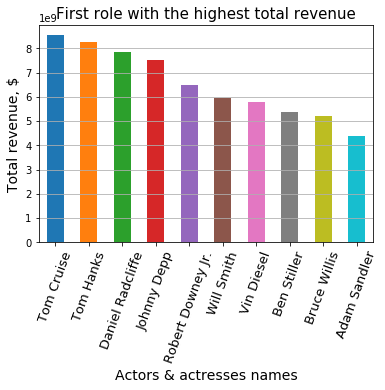

In [43]:
df.groupby('cast_1')['revenue'].sum().sort_values(ascending=False).head(10).plot(kind='bar')

plt.title('First role with the highest total revenue', size=15)
plt.grid(True, axis='y')
plt.ylabel('Total revenue, $', size=14)
plt.xlabel('Actors & actresses names', size=14)
plt.xticks(size=13, rotation=70);

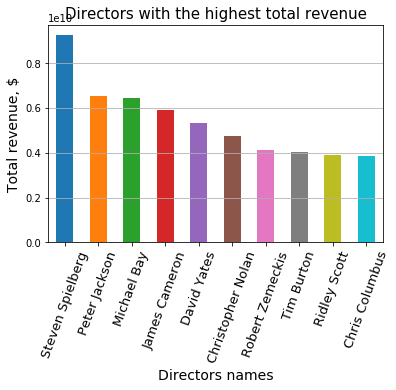

In [44]:
df.groupby('crew_Director')['revenue'].sum().sort_values(ascending=False).head(10).plot(kind='bar')

plt.title('Directors with the highest total revenue', size=15)
plt.grid(True, axis='y')
plt.ylabel('Total revenue, $', size=14)
plt.xlabel('Directors names', size=14)
plt.xticks(size=13, rotation=70);

In [45]:
# Most productive in total amount of created movies actors & actresses
df['cast'].str.extractall('\'name\': \'(?P<name>[\w\s\d\.,-]*)\'').reset_index()['name'].value_counts().head()

Bess Flowers         240
Christopher Lee      148
John Wayne           125
Samuel L. Jackson    122
Michael Caine        110
Name: name, dtype: int64

In [46]:
# create table with all actors & actresses for each movie with it success rate and genre
temp = df['cast'].str.extractall('\'name\': \'(?P<name>[\w\s\d\.,-]*)\'').reset_index()

temp = pd.merge(left=temp[['level_0', 'name']], 
                right=df.reset_index()[['index', 'year', 'genres_1', 'success']], 
                left_on='level_0', right_on='index')

temp.head()

,level_0,name,index,year,genres_1,success
0,0,Tom Hanks,0,1995.0,Animation,12.451801
1,0,Tim Allen,0,1995.0,Animation,12.451801
2,0,Don Rickles,0,1995.0,Animation,12.451801
3,0,Jim Varney,0,1995.0,Animation,12.451801
4,0,Wallace Shawn,0,1995.0,Animation,12.451801


In [47]:
# for each actor & actress find mean year of their activity, number of movies, mean success rate 
act_stat = temp.groupby(by='name')[['year', 'success', 'index']]\
.aggregate({'year': 'mean', 'success': 'mean', 'index': 'count'}).reset_index()\
.rename(columns={'index': 'total_count'})
act_stat.head()

,name,year,success,total_count
0,Jorge de los Reyes,2013.0,NaN,1
1,Liu Jin,2009.0,NaN,1
2,Alistair Freeland,2005.0,NaN,1
3,Antanas Barčas,1965.0,NaN,2
4,Belen Blanco,2005.5,NaN,2


In [48]:
# for each actor & actress find it most common genre
temp = temp.groupby(by=['name', 'genres_1'])['index'].count().reset_index()\
.sort_values(by=['name', 'index', 'genres_1'], ascending=False).groupby(by=['name']).nth(0).reset_index()\
.rename(columns={'index': 'genre_count', 'genres_1': 'genre'})
temp.head()

,name,genre,genre_count
0,Jorge de los Reyes,Drama,1
1,Liu Jin,Drama,1
2,Alistair Freeland,Horror,1
3,Antanas Barčas,Drama,2
4,Belen Blanco,Horror,1


In [49]:
temp = temp.merge(act_stat, on='name')

In [50]:
# most stable recent popular actor & actress (play same genre)
temp.loc[(temp[('year')] > 2000) & (temp['total_count'] > 10), :]\
.sort_values(by='genre_count', ascending=False).head(10)

,name,genre,genre_count,year,success,total_count
59401,Frank Welker,Animation,41,2001.177570,4.526399,107
174504,Steven Seagal,Action,40,2004.604167,2.433600,48
40119,Danny Trejo,Action,40,2006.376238,2.305906,101
46195,Dolph Lundgren,Action,38,2005.123077,2.151407,65
18349,Ben Stiller,Comedy,37,2004.061538,2.914107,65
191274,Will Ferrell,Comedy,37,2006.686275,2.659625,51
173835,Steve Buscemi,Comedy,37,2001.584158,3.238205,101
146008,Paul Rudd,Comedy,36,2007.245283,2.971891,53
175689,Susan Sarandon,Drama,36,2000.358696,9.762461,92
164258,Samuel L. Jackson,Action,36,2002.483607,3.458106,122


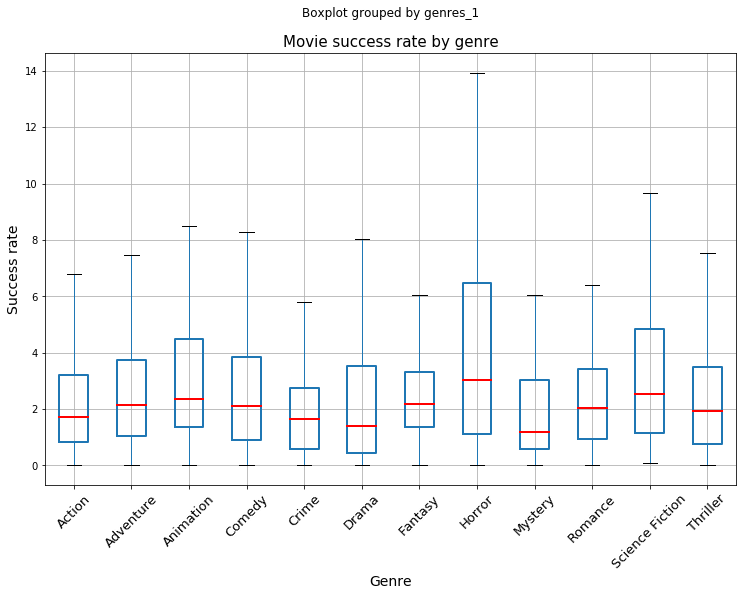

In [51]:
main_genres = ['Drama', 'Comedy', 'Thriller', 'Romance', 'Action', 'Horror', 'Crime', 'Adventure', 
               'Science Fiction', 'Mystery', 'Fantasy', 'Mystery', 'Animation']

temp = df.loc[df['genres_1'].isin(main_genres) & (df['year'] >= 2000) 
              & (df['year'] <= 2016) & df['success'].notna()]

result =temp.boxplot(column='success', by='genres_1', showfliers=False, rot=45, figsize=(12, 8), return_type='dict')

[(med.set_color('r'), med.set_linewidth(2)) for med in result[0]['medians']]
[ med.set_linewidth(2) for med in result[0]['boxes']]
plt.title("Movie success rate by genre", size=15)
plt.xlabel('Genre', size=14)
plt.xticks(size=13)
plt.ylabel('Success rate', size=14);

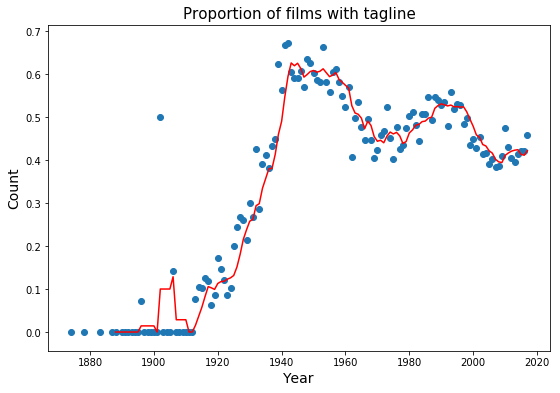

In [52]:
# check tagline proportion in time 
def tagline_proporshion(x):
    s = 0
    for i in x:
        if i is np.nan:
            pass
        else:
            s += 1
    return s / x.shape[0]

temp = df.groupby(by='year')['tagline'].apply(tagline_proporshion).reset_index()

plt.figure(figsize=(9, 6))
plt.title('Proportion of films with tagline', size=15)
plt.scatter(x=temp['year'], y=temp['tagline'])
plt.plot(temp['year'], temp['tagline'].rolling(5).mean(), 'r')
plt.xlabel('Year', size=14)
plt.ylabel('Count', size=14);

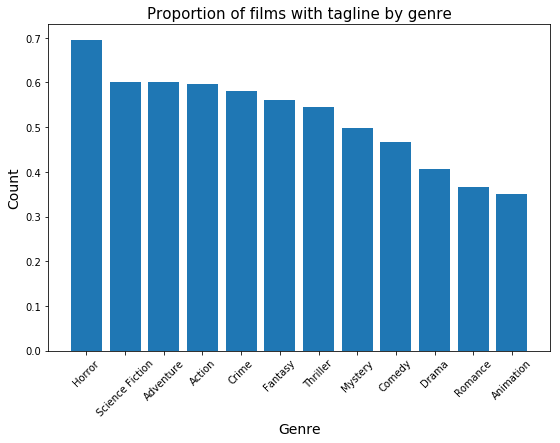

In [53]:
temp = df.loc[df['genres_1'].isin(main_genres)].groupby(by='genres_1')['tagline']\
.apply(tagline_proporshion).reset_index().sort_values(by='tagline', ascending=False)

plt.figure(figsize=(9, 6))
plt.title('Proportion of films with tagline by genre', size=15)
plt.bar(x=range(len(main_genres)-1), height=temp['tagline'], tick_label=temp['genres_1'])
plt.xticks(rotation=45)
plt.xlabel('Genre', size=14)
plt.ylabel('Count', size=14);

In [54]:
stop_words = set(nltk.corpus.stopwords.words('english')) 

In [55]:
def most_common_word(x, stop_words):
    counter = collections.Counter()
    wnl = nltk.WordNetLemmatizer()
    
    x = ' '.join(x)
    x = re.sub(r"[\d\W]+", " ", x)
    x = nltk.tokenize.word_tokenize(x) 
    x = [wnl.lemmatize(w.lower()) for w in x if w.lower() not in stop_words] 
    counter.update(x)
    
    return [word.capitalize() for word, count in counter.most_common(10)]

In [56]:
temp = df.loc[df['genres_1'].isin(main_genres) & df['tagline'].notna()].groupby(by='genres_1')['tagline']\
.apply(most_common_word, stop_words=stop_words)

In [57]:
# Most common words in headline in different genre and there are a lot of similarity between them
pd.DataFrame(data={idx: temp[idx] for idx in temp.index})

,Action,Adventure,Animation,Comedy,Crime,Drama,Fantasy,Horror,Mystery,Romance,Science Fiction,Thriller
0,One,Adventure,Adventure,Love,One,Love,World,Terror,Murder,Love,Man,One
1,Man,One,One,Comedy,Man,One,Love,Evil,Love,Story,World,Never
2,World,World,New,One,Murder,Story,Man,One,Secret,Life,Time,Love
3,Time,Time,World,Life,Killer,Life,One,Never,Every,One,Space,Life
4,Back,Man,Time,Get,Life,Man,Ever,Dead,Mystery,Never,Earth,Man
5,Get,Love,Love,Story,Love,Woman,Believe,Die,Ever,Woman,One,Time
6,Never,New,Back,Time,Story,World,Comedy,Hell,Life,Comedy,Future,Murder
7,Kill,Back,Get,Never,Way,Never,Story,Horror,Never,Man,Battle,Killer
8,Cop,Story,Life,Girl,Woman,Time,New,Fear,See,World,Year,Evil
9,Adventure,Hero,Family,Man,Crime,Two,Adventure,Come,Could,Girl,Human,Story


In [58]:
def preprocess_text(x, stop_words):
    """Remove special symbols and numbers, make lemmatization and lower text"""
    wnl = nltk.WordNetLemmatizer()
    
    x = ' '.join(x)
    x = re.sub(r"[\d\W]+", " ", x)
    x = nltk.tokenize.word_tokenize(x) 
    x = [wnl.lemmatize(w.lower()) for w in x if w.lower() not in stop_words] 
    
    return ' '.join(x)

In [59]:
# group overview by genre and apply preprocessing function
temp = df.loc[df['genres_1'].isin(main_genres) & df['overview'].notna() & (df['original_language'] == 'en')]\
.groupby(by='genres_1')['overview'].apply(preprocess_text, stop_words=stop_words)

In [60]:
tf = TfidfVectorizer(analyzer='word', ngram_range=(2, 2), min_df=0.4, max_df=0.8, stop_words='english', 
                     max_features=300000)
tf.fit(temp)

# extract top n words with highest weight
d = {}
n = 10
for genre in main_genres:
    transformed_text = tf.transform([temp[genre]])
    feature_array = np.array(tf.get_feature_names())
    tfidf_sorting = np.argsort(transformed_text.toarray()).flatten()[::-1]

    top_n = feature_array[tfidf_sorting][:n]
    d[genre] = top_n

# key phrases in overview for each genre, amount of intersection can be varied using min_df, max_df parameter
pd.DataFrame(data=d)

,Action,Adventure,Animation,Comedy,Crime,Drama,Fantasy,Horror,Mystery,Romance,Science Fiction,Thriller
0,martial art,snow white,animated film,romantic comedy,drug dealer,working class,short film,horror film,prime suspect,love life,sci fi,psychological thriller
1,kung fu,secret agent,fairy tale,love life,police officer,love affair,live action,killing spree,scotland yard,romantic comedy,science fiction,police officer
2,drug lord,king arthur,animated short,ex girlfriend,life crime,change life,beautiful princess,flesh eating,police officer,meet fall,space station,hit man
3,police officer,save family,stop motion,ex boyfriend,bank robber,coming age,black magic,human flesh,hotel room,night stand,post apocalyptic,dark secret
4,bounty hunter,cross country,short film,girl dream,hit man,african american,king arthur,mysterious death,new england,thing complicated,crash land,perfect life
5,cia agent,new world,north pole,comedy film,small time,life story,make wish,group people,mysterious woman,return new,animated short,spiral control
6,mob bos,save world,walt disney,school student,district attorney,based novel,department store,evil spirit,private detective,comedy set,return earth,begin suspect
7,drug dealer,classic tale,star war,brand new,sent prison,come term,fairy tale,soon discover,crime scene,spends time,st century,fight survival
8,high tech,real world,save day,ex wife,scotland yard,school student,magical power,haunted house,district attorney,upper class,life form,family man
9,hong kong,lost city,comic book,beverly hill,maximum security,single mother,past life,evil force,gruesome murder,blind date,short film,prove innocence


In [61]:
# group title by genre and apply preprocessing function
temp = df.loc[df['genres_1'].isin(main_genres) & df['title'].notna() & (df['original_language'] == 'en')]\
.groupby(by='genres_1')['title'].apply(preprocess_text, stop_words=stop_words)

In [62]:
tf = TfidfVectorizer(analyzer='word', ngram_range=(1, 2), min_df=0.5, max_df=0.85, stop_words='english', 
                     max_features=300000)
tf.fit(temp)

# extract top n words with highest weight
d = {}
n = 10
for genre in main_genres:
    transformed_text = tf.transform([temp[genre]])
    feature_array = np.array(tf.get_feature_names())
    tfidf_sorting = np.argsort(transformed_text.toarray()).flatten()[::-1]

    top_n = feature_array[tfidf_sorting][:n]
    d[genre] = top_n

# key words in title for each genre, amount of intersection can be varied using min_df, max_df parameter
pd.DataFrame(data=d)

,Action,Adventure,Animation,Comedy,Crime,Drama,Fantasy,Horror,Mystery,Romance,Science Fiction,Thriller
0,gun,adventure,christmas,live,murder,american,dragon,zombie,case,christmas,space,fear
1,kill,sea,adventure,christmas,killer,angel,christmas,dracula,murder,west,moon,evil
2,ninja,captain,tom,like,crime,good,princess,evil,charlie,affair,planet,double
3,hard,pirate,brown,party,thief,song,warrior,massacre,shadow,god,alien,road
4,justice,journey,toy,american,gun,young,wish,horror,midnight,want,mar,light
5,cop,prince,high,high,charlie,red,beauty,nightmare,fear,old,battle,darkness
6,killer,land,cat,family,case,road,santa,terror,lake,sun,project,summer
7,american,queen,hero,good,kill,like,hunter,frankenstein,like,paris,turtle,cold
8,soldier,harry,charlie,hollywood,stranger,summer,frankenstein,iii,holmes,la,doctor,zero
9,red,planet,carol,school,true,child,miracle,vampire,sherlock holmes,valentine,invasion,stranger


In [63]:
# fill NA values
# df['overview'] = df['overview'].fillna('')
# df['tagline'] = df['tagline'].fillna('')

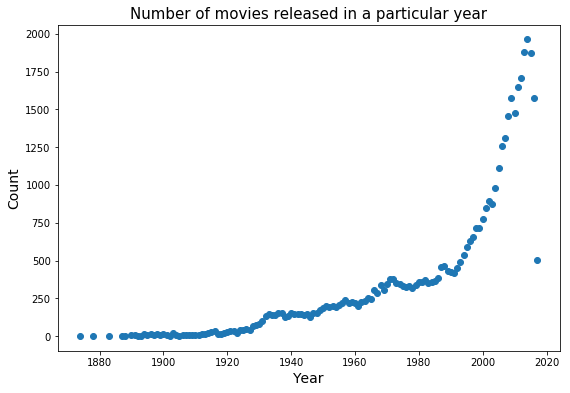

In [64]:
temp = df.loc[df['year'].notna() & (df['year'] <= 2018), 'year'].value_counts().reset_index()\
.rename(columns={'year': 'count', 'index': 'year'}).sort_values(by='year')

plt.figure(figsize=(9, 6))
plt.title('Number of movies released in a particular year', size=15)
plt.scatter(x=temp['year'], y=temp['count'])
plt.xlabel('Year', size=14)
plt.ylabel('Count', size=14);

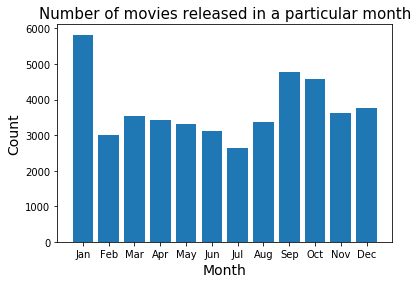

In [65]:
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
temp = df.loc[df['month'].notna(), 'month'].value_counts().reset_index()
temp['index2'] = temp['index'].apply(lambda x: month_order[int(x) - 1])
temp = temp.sort_values(by='index')

plt.figure(figsize=(6, 4))
plt.title('Number of movies released in a particular month', size=15)
plt.bar(x=range(12), height=temp['month'], tick_label=temp['index2'])
plt.xlabel('Month', size=14)
plt.ylabel('Count', size=14);

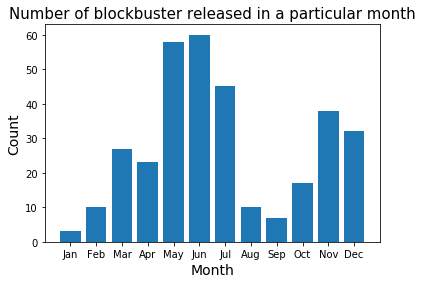

In [66]:
temp = df.loc[df['month'].notna() & (df['budget'] > 1e+8), 'month'].value_counts().reset_index()
temp['index2'] = temp['index'].apply(lambda x: month_order[int(x) - 1])
temp = temp.sort_values(by='index')

plt.figure(figsize=(6, 4))
plt.title('Number of blockbuster released in a particular month', size=15)
plt.bar(x=range(12), height=temp['month'], tick_label=temp['index2'])
plt.xlabel('Month', size=14)
plt.ylabel('Count', size=14);

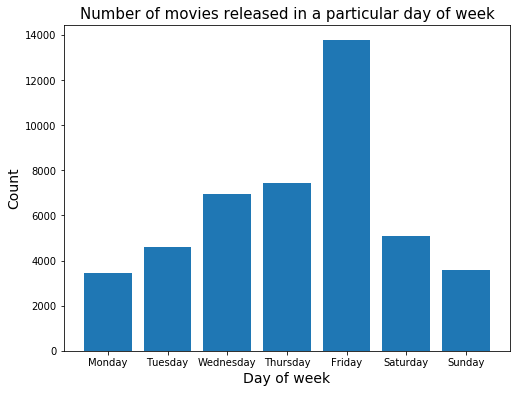

In [67]:
day_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
temp = df.loc[df['day_of_week'].notna(), 'day_of_week'].value_counts()[day_of_week]

plt.figure(figsize=(8, 6))
plt.title('Number of movies released in a particular day of week', size=15)
plt.bar(x=range(7), height=temp.values, tick_label=temp.index)
plt.xlabel('Day of week', size=14)
plt.ylabel('Count', size=14);

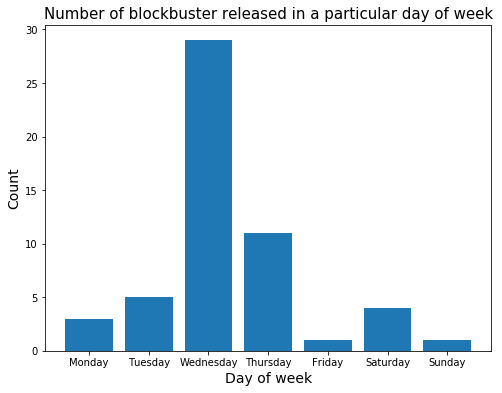

In [68]:
temp = df.loc[df['day_of_week'].notna() & (df['budget'] >= 2e+8) & (df['year'] >= 2000), 
              'day_of_week'].value_counts()[day_of_week]

plt.figure(figsize=(8, 6))
plt.title('Number of blockbuster released in a particular day of week', size=15)
plt.bar(x=range(7), height=temp.values, tick_label=temp.index)
plt.xlabel('Day of week', size=14)
plt.ylabel('Count', size=14);

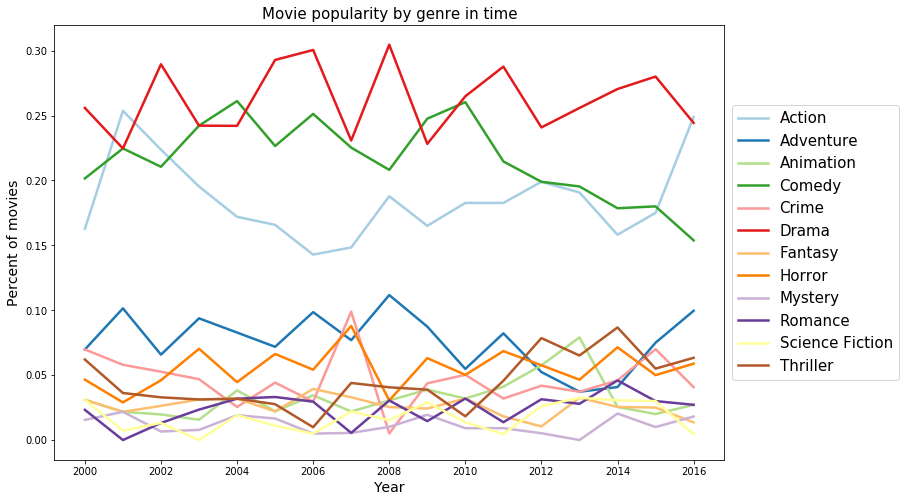

In [69]:
temp = df.loc[df['genres_1'].isin(main_genres) & 
                        (df['year'] >= 2000) & 
                        (df['year'] <= 2016) &
                        df['success'].notna()]

temp = pd.crosstab(temp['year'], temp['genres_1']).apply(lambda x: x/x.sum(), axis=1)

temp.plot(kind='line', stacked=False, colormap='Paired', figsize=(12, 8), linewidth=2.5)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=15)
plt.title('Movie popularity by genre in time', size=15)
plt.xlabel('Year', size=14)
plt.ylabel('Percent of movies', size=14);

In [70]:
df = df.drop(['cast', 'crew', 'belongs_to_collection', 'genres', 'production_companies', 
              'production_countries', 'release_date', 'belongs_to_collection'], axis=1)

In [71]:
df.isna().sum()

id                                  0
budget                          36441
original_language                  10
overview                          920
popularity                          0
revenue                         37853
runtime                          1983
tagline                         24714
title                               0
vote_average                        0
vote_count                          0
year                               78
month                              78
day_of_week                        78
success                         39734
country_name                        0
franchise_name                      0
companie_name                       0
crew_Director                    1040
crew_Screenplay                 29407
crew_Producer                   23221
crew_Executive Producer         36705
crew_Music                      38830
crew_Director of Photography    26076
cast_1                           2691
cast_gender_1                    2359
cast_2      

In [72]:
df = df.drop(df.loc[df['year'].isna() | df['original_language'].isna() | df['title'].isna() | \
                    df['overview'].isna()].index, axis=0)

In [73]:
df['description'] = df['title'] + ' ' + df['tagline'].fillna('') + ' ' + df['overview']

In [74]:
def preprocess_description(x, stop_words):
    """Remove special symbols and numbers, make lemmatization and lower text"""
    wnl = nltk.WordNetLemmatizer()
    
    x = re.sub(r"[\d\W]+", " ", x)
    x = nltk.tokenize.word_tokenize(x) 
    x = [wnl.lemmatize(w.lower()) for w in x if w.lower() not in stop_words] 
    
    return ' '.join(x)

In [75]:
df['description'] = df['description'].apply(preprocess_description, stop_words=stop_words)

In [78]:
df = df.drop(['overview', 'tagline'], axis=1)

In [76]:
keywords = pd.read_csv(os.path.join(DATA_PATH, 'keywords.csv'))
df = df.merge(keywords, on='id')
del keywords

In [92]:
def join_keywords(x):
    p = re.compile('\'name\': \'(?P<name>[\w\s\d\.,-]*)\'')
    return ' '.join(re.findall(p, x))

In [94]:
df['keywords'] = df['keywords'].apply(join_keywords)

In [95]:
df.head(5).T

,0,1,2,3,4
id,862,8844,15602,31357,11862
budget,3e+07,6.5e+07,NaN,1.6e+07,NaN
original_language,en,en,en,en,en
popularity,21.9469,17.0155,11.7129,3.85949,8.38752
revenue,3.73554e+08,2.62797e+08,NaN,8.14522e+07,7.65789e+07
runtime,81,104,101,127,106
title,Toy Story,Jumanji,Grumpier Old Men,Waiting to Exhale,Father of the Bride Part II
vote_average,7.7,6.9,6.5,6.1,5.7
vote_count,5415,2413,92,34,173
year,1995,1995,1995,1995,1995


In [96]:
df.to_csv(path_or_buf=os.path.join(DATA_PATH, 'clean.csv'), index=False)